In [175]:
import pandas as pd
import numpy as np
import plotly.express as px
from pathlib import Path
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [176]:
DATA_ROOT = Path("data")
PROCESSED_DATA = DATA_ROOT / "processed"

trends = pd.read_csv(PROCESSED_DATA / "trends.csv", index_col=0, parse_dates=True)
prices = pd.read_csv(PROCESSED_DATA / "prices.csv", index_col=0, parse_dates=True)
volumes = pd.read_csv(PROCESSED_DATA / "volumes.csv", index_col=0, parse_dates=True)

trends.shape, prices.shape, volumes.shape

((1766, 1574), (1766, 476), (1766, 476))

In [177]:
def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    # return (df - df.min()) / (df.max() - df.min())
    return df/df.sum(axis=0)

trends = normalize_df(trends)
prices = normalize_df(prices)
volumes = normalize_df(volumes)

unified = pd.concat([trends, volumes], axis=1).T
unified.shape

(2050, 1766)

In [178]:
import json

with open('cfg/stock_data.json') as f:
    stock_data = json.load(f)['entries']
    
with open('cfg/stock_data_clustering.json') as f:
    stock_data_clustering = json.load(f)['entries']
    
    
with open('cfg/etf_stocks.json') as f:
    etf_stocks = json.load(f)['entries']

In [179]:
stock_data =stock_data+stock_data_clustering+etf_stocks

In [189]:
stock_df = pd.DataFrame(stock_data)
stock_df = stock_df.drop(columns=['start', 'end','aggregate','interval','period'])
stock_df['tickers'] = stock_df.apply(lambda x: [x['ticker']] if isinstance(x['ticker'], str) else x['tickers'], axis=1)
stock_df = stock_df.drop(columns=['ticker'])
stock_df = stock_df.drop_duplicates(subset=['tickers'])
stock_df['num_tickers'] = stock_df['tickers'].apply(len)
stock_df['is_sector'] = stock_df['name'].str.contains('US_')
stock_df = stock_df[stock_df['name'].isin(prices.columns)]

single_stocks = stock_df.query('not is_sector and num_tickers==1')
is_etf = single_stocks['description'].fillna("").str.lower().str.contains('etf|index|tracks')

stock_df['is_etf'] = False
stock_df.loc[is_etf.index, 'is_etf'] = is_etf

In [190]:
stock_df[stock_df['is_sector']]['tickers'].tolist()

[['XLK'],
 ['XLV'],
 ['XLF'],
 ['XLY'],
 ['XLP'],
 ['XLI'],
 ['XLE'],
 ['XLU'],
 ['XLB'],
 ['XLC'],
 ['XLRE'],
 ['IBB'],
 ['KBE'],
 ['KRE'],
 ['IYT'],
 ['ITB']]

In [191]:
stock_df[stock_df['is_etf']].tickers.apply(lambda x: x[0]).tolist()

['^GSPC',
 'ICLN',
 'TAN',
 'PHO',
 'EIS',
 'ISRA',
 'FRDM',
 'RSX',
 'ERUS',
 'SHE',
 'SPY',
 'QQQ',
 'IWM',
 'DIA']

In [192]:
holdings = pd.read_csv('etf_holdings_top50.csv')
holdings = holdings.groupby('ETF').agg(list)

tickers = stock_df.query('not is_sector and num_tickers==1').tickers.apply(lambda x:x[0]).to_list()
holdings['data_tickers'] = holdings['Ticker'].apply(lambda x: set(x).intersection(tickers))
holdings['num_data_tickers'] = holdings['data_tickers'].apply(len)
coloring = holdings[holdings['num_data_tickers']>1].drop(columns=['Ticker'])

In [240]:
# for each etf in holdings, find its description from stock_df
holdings_descriptions = stock_df.query('is_etf or is_sector')
holdings_descriptions['tickers'] = holdings_descriptions['tickers'].apply(lambda x: x[0])
holdings_descriptions = holdings_descriptions.set_index('tickers')
holdings['description'] = holdings.merge(holdings_descriptions, left_on='ETF', right_index=True)['description_y']

/var/folders/hm/y24_51v94jj_qlbxgg2t7kmw0000gn/T/ipykernel_55544/1197410361.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [194]:
# all_tickers = holdings['Ticker'].to_list()
# all_tickers = [item for sublist in all_tickers for item in sublist]
# pd.Series(all_tickers).to_csv('all_etf_tickers.csv', index=False)

In [ ]:
# etf_stock_cfg = {"output_dir": "./data/market"}
# entries = []
# for ticker in all_tickers:
#     entries.append({
#         "name": ticker,
#         "ticker": ticker,
#         "period": "5y",
#         "interval": "1d",})
# etf_stock_cfg['entries'] = entries

# json.dump(etf_stock_cfg, open('cfg/etf_stocks.json', 'w'), indent=4)


/Users/ronraisch/miniforge3/envs/needle/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



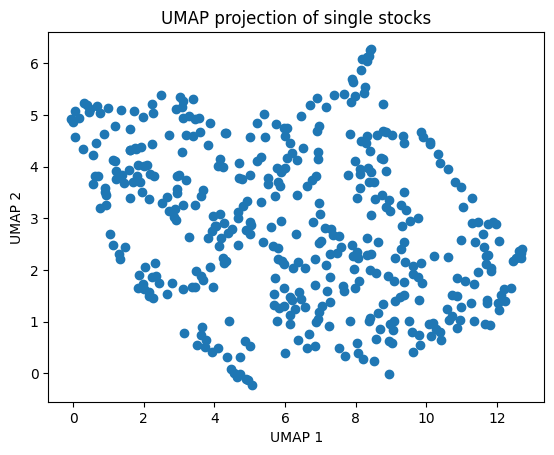

In [241]:
single_stocks = stock_df.query('not is_sector and num_tickers==1 and not is_etf')

# use UMAP to reduce dimensionality of single stocks
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)
# reducer = 
reduced_single_stocks = reducer.fit_transform(prices[single_stocks['name']].T)


plt.scatter(reduced_single_stocks[:, 0], reduced_single_stocks[:, 1])
plt.title('UMAP projection of single stocks')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [250]:
holdings.loc[coloring.index[0]].name

'DIA'

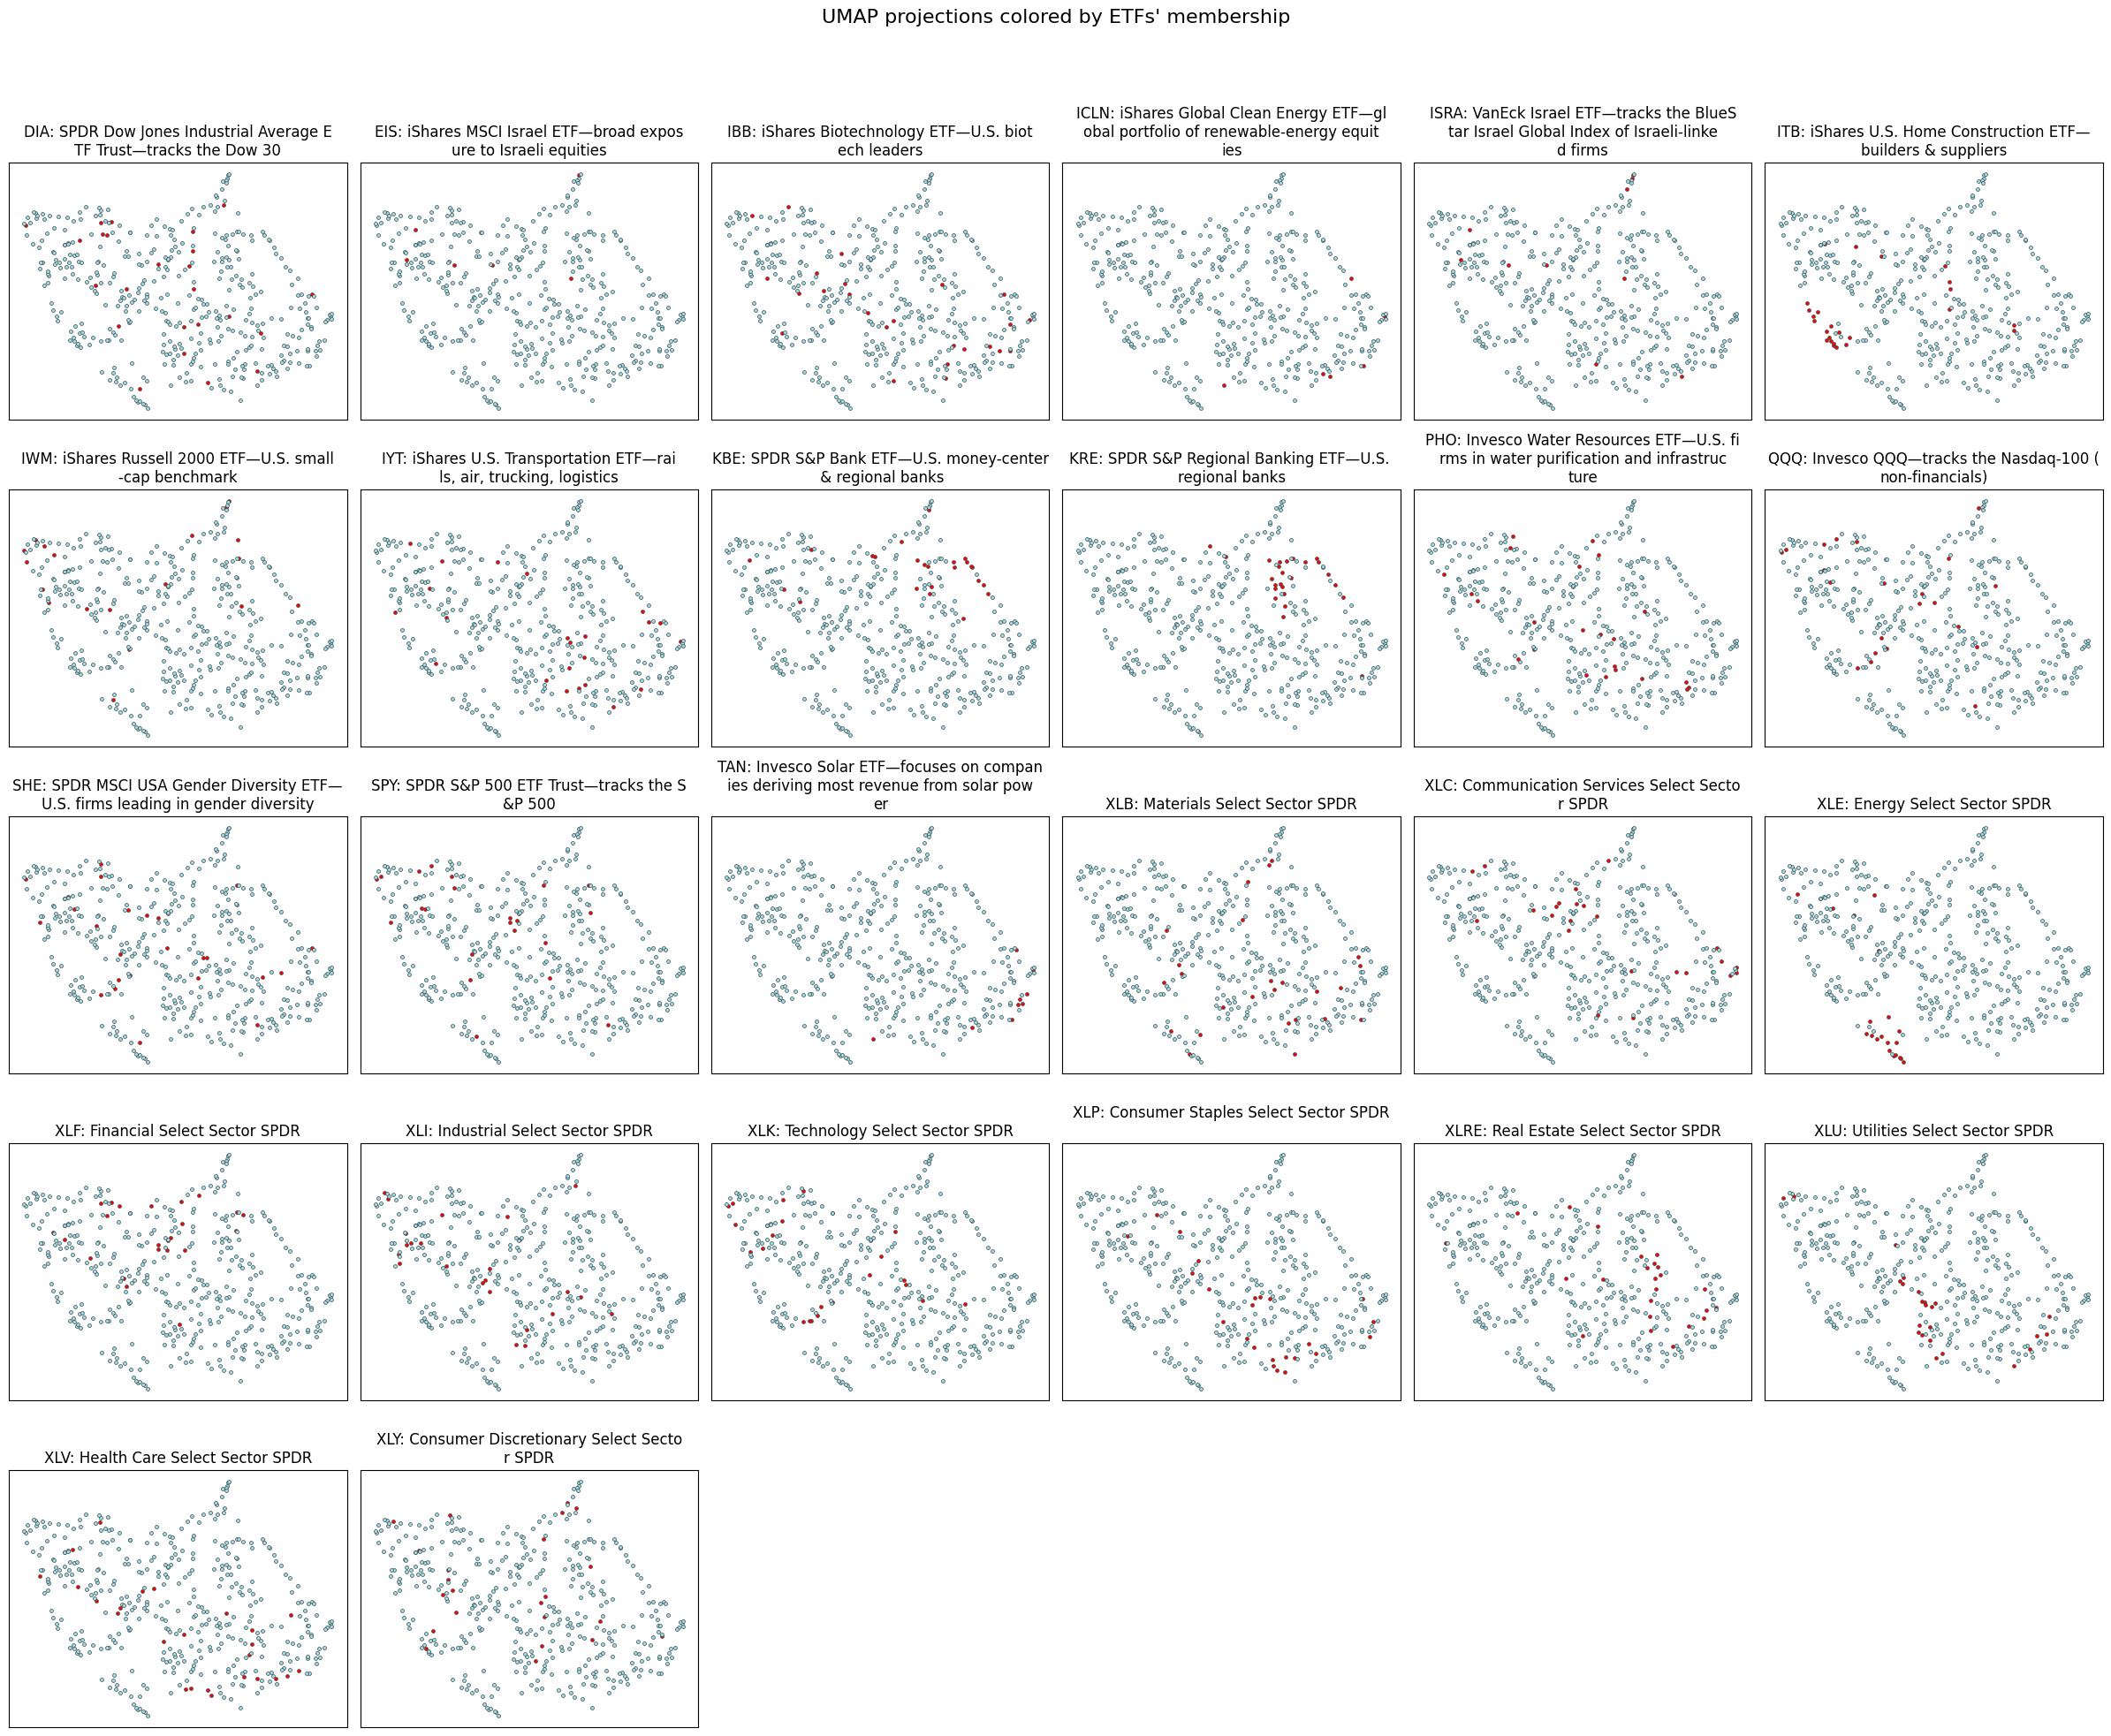

In [251]:
import math

# determine grid size
n = len(coloring)
cols = int(math.ceil(math.sqrt(n)))
rows = int(math.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for i in range(len(coloring.index)):
    etf_name = holdings.loc[coloring.index[i]]['description']
    etf_name =  holdings.loc[coloring.index[i]].name + ": " + etf_name
    # make the etf_name use \n to break lines every 40 characters
    etf_name = '\n'.join([etf_name[j:j+40] for j in range(0, len(etf_name), 40)])
    if etf_name.endswith('.'):
        etf_name = etf_name[:-1]
        
    members = set(coloring.iloc[i, 0])
    in_etf = single_stocks['tickers'].apply(lambda x: x[0] in members)

    ax = axes[i]
    # plot points in ETF
    ax.scatter(
        reduced_single_stocks[in_etf, 0],
        reduced_single_stocks[in_etf, 1],
        c='red', s=8, edgecolors='darkslategray', linewidth=0.5, label='In'
    )
    # plot points not in ETF
    ax.scatter(
        reduced_single_stocks[~in_etf, 0],
        reduced_single_stocks[~in_etf, 1],
        c='#ADD8E6', s=8, edgecolors='darkslategray', linewidth=0.5, label='Not in'
    )
    ax.set_title(etf_name)
    ax.set_xticks([])
    ax.set_yticks([])

# turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("UMAP projections colored by ETFs' membership", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [216]:
dbscan = DBSCAN(eps=0.4, min_samples=5)
labels = dbscan.fit_predict(reduced_single_stocks)
count = np.unique(labels, return_counts=True)
pd.Series(count[1], index=count[0]).sort_index()

-1     58
 0     20
 1     13
 2     15
 3     33
 4     17
 5     15
 6     23
 7     20
 8     18
 9     13
 10    25
 11    23
 12    29
 13    32
 14     6
 15    14
 16    12
 17     5
 18     9
 19     5
 20     8
 21     5
 22     9
 23     3
dtype: int64

In [217]:
mask = labels != -1

fig = px.scatter(
    x=reduced_single_stocks[mask, 0],
    y=reduced_single_stocks[mask, 1],
    color=labels[mask].astype(str),
    hover_name=single_stocks[mask]['name'],
    title="DBSCAN Clustering (UMAP visualization) - noise points removed",
    width=600,
    height=600
    
)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

In [39]:
# map labels to original indices in unified
label_map = {unified.index[i]: labels[i] for i in range(len(labels))}
label_series = pd.Series(label_map)
label_series = label_series[label_series != -1]  # remove outliers
label_series.sort_values().to_csv(PROCESSED_DATA / "cluster_labels.csv", header=["cluster"])

In [40]:
# make a json with cluster to list of items
cluster_map = {}
for idx, cluster in label_series.items():
    if cluster not in cluster_map:
        cluster_map[cluster] = []
    cluster_map[cluster].append(idx)
import json
with open(PROCESSED_DATA / "clusters.json", "w") as f:
    json.dump(cluster_map, f, indent=4)
    

In [41]:
with open(PROCESSED_DATA / 'cluster_GPT.json') as f:
    gpt_clusters = json.load(f)


In [50]:
clusters = list(gpt_clusters.keys())
from typing import Dict, Optional
from dataclasses import dataclass

@dataclass
class ClusterInfo:
    name: str
    description: str
    scores: Dict[str, float]
    coherence: float


cluster_infos = []
for cluster in clusters:
    info = gpt_clusters[cluster]
    cluster_infos.append(ClusterInfo(
        name=cluster,
        description=info["description"],
        scores=info["scores"],
        coherence=info["coherence"]
    ))

Text(0.5, 0, 'Coherence Score')

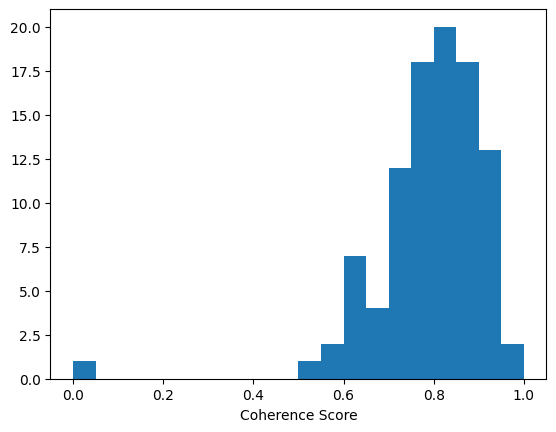

In [ ]:
coherence_scores = [info.coherence for info in cluster_infos]
import matplotlib.pyplot as plt
plt.hist(coherence_scores, bins=20)
plt.xlabel("Coherence Score")
c

In [53]:
prices

,ISRG,RSX,US_Transportation,Russell2000,US_Biotech,Google,V,US_Consumer_Staples,US_Consumer_Discretionary,BAC,...,MA,SLB,AAPL,HydrogenCCS,SAP,ASML,JNJ,CRM,CleanWater,BLK
date,,,,,,,,,,,,,,,,,,,,,
2020-09-05,0.000398,0.000957,0.000435,0.000413,0.000524,0.000332,0.000455,0.000462,0.000460,0.000378,...,0.000456,0.000252,0.000384,0.000382,0.000529,0.000292,0.000483,0.000598,0.000439,0.000376
2020-09-06,0.000393,0.000948,0.000434,0.000411,0.000522,0.000329,0.000452,0.000459,0.000459,0.000374,...,0.000454,0.000249,0.000377,0.000381,0.000525,0.000288,0.000482,0.000590,0.000437,0.000374
2020-09-07,0.000387,0.000940,0.000432,0.000409,0.000519,0.000326,0.000450,0.000457,0.000457,0.000370,...,0.000453,0.000246,0.000371,0.000380,0.000521,0.000284,0.000481,0.000582,0.000435,0.000372
2020-09-12,0.000388,0.000954,0.000440,0.000409,0.000530,0.000320,0.000452,0.000459,0.000460,0.000368,...,0.000455,0.000237,0.000365,0.000383,0.000534,0.000292,0.000482,0.000581,0.000445,0.000364
2020-09-13,0.000391,0.000958,0.000442,0.000413,0.000539,0.000320,0.000455,0.000460,0.000462,0.000369,...,0.000459,0.000238,0.000369,0.000386,0.000536,0.000294,0.000483,0.000584,0.000446,0.000365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-23,0.000827,0.000305,0.000662,0.000656,0.000559,0.000810,0.000821,0.000659,0.000741,0.000777,...,0.000790,0.000512,0.000710,0.000492,0.001055,0.000599,0.000631,0.000642,0.000574,0.000843
2025-07-24,0.000805,0.000305,0.000654,0.000647,0.000559,0.000819,0.000818,0.000657,0.000728,0.000781,...,0.000792,0.000513,0.000709,0.000492,0.001039,0.000606,0.000633,0.000643,0.000575,0.000841
2025-07-25,0.000817,0.000305,0.000661,0.000649,0.000559,0.000823,0.000825,0.000658,0.000735,0.000782,...,0.000799,0.000517,0.000709,0.000500,0.001046,0.000594,0.000628,0.000646,0.000579,0.000845


In [63]:
X_embedded.shape

(92, 2)

In [80]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, random_state=0)
X_embedded = reducer.fit_transform(prices.T)

dbscan = DBSCAN(eps=0.8, min_samples=5)
labels = dbscan.fit_predict(X_embedded)
count = np.unique(labels, return_counts=True)
pd.Series(count[1], index=count[0]).sort_index()

/Users/ronraisch/miniforge3/envs/needle/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



0    23
1    38
2    20
3     5
4     6
dtype: int64

In [83]:
mask = labels != -2

fig = px.scatter(
    x=X_embedded[mask, 0],
    y=X_embedded[mask, 1],
    color=labels[mask].astype(str),
    hover_name=[prices.columns[i] for i in np.where(mask)[0]],
    width=600,
    height=600
)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

In [82]:
prices.columns

Index(['ISRG', 'RSX', 'US_Transportation', 'Russell2000', 'US_Biotech',
       'Google', 'V', 'US_Consumer_Staples', 'US_Consumer_Discretionary',
       'BAC', 'ISRA', 'SYK', 'NOW', 'ERUS', 'LLY', 'COST', 'BKNG', 'MRK',
       'TSM', 'ICLN', 'ORCL', 'TAN', 'AMZN', 'INTC', 'US_Tech_Sector', 'APPLE',
       'TMO', 'SHE', 'ADSK', 'NEE', 'MSFT', 'UBER',
       'Rebuilding_America_Grid_Chips', 'GenderDiversity', 'Nasdaq100', 'AMD',
       'NVDA', 'US_Regional_Banks', 'XOM', 'CVX', 'US_Industrials', 'IBM',
       'LargeTech', 'AIEthics', 'US_Homebuilders', 'GS',
       'US_Communication_Services', 'PANW', 'US_Real_Estate',
       'US_Financials_Sector', 'US_HealthCare_Sector', 'CircularEconomy',
       'AI_Infrastructure_Stack', 'US_Banks', 'SupportUkraine', 'NFLX', 'JPM',
       'TSLA', 'COP', 'US_Materials', 'DHR', 'GOOGL', 'VeteranFriendly',
       'Tesla', 'META', 'CRWD', 'SHOP', 'AVGO', 'REGN', 'US_Energy',
       'US_Utilities', 'DowJones30', 'PHO', 'EIS', 'S&P500_ETF', 'FRDM',
       

In [1]:
prices

NameError: name 'prices' is not defined